In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import os
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
from midi2audio import FluidSynth
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

C:\Users\Frederico\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Frederico\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Loading data

In [2]:
import os
from tqdm.notebook import tqdm
#Loading the list of chopin's midi files as stream 
filepath = "./Datasets/Test/"
#Getting midi files
all_midis= []
for i in tqdm(os.listdir(filepath)):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

  0%|          | 0/11 [00:00<?, ?it/s]

In [3]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 9402


## Data exploration

In [4]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['E5', 'E2', 'E-5', 'B4', '4.7', 'D5', 'A2', 'C5', 'F#4', '0.4', 'C5', 'B2', 'B4', 'E-4', '3.7.9', '6.7', 'E2', 'F#4', 'E4', 'B3', 'E4', 'G4', 'B4', 'E5', 'E2', 'E-5', 'B4', '4.7', 'D5', 'A2', 'C5', 'F#4', '0.4', 'C5', 'B2', 'B4', 'E-4', '3.7.9', '4.7.11', 'E2', 'E5', 'E2', 'E-5', 'B4', '4.7', 'D5', 'A2', 'C5', 'F#4', '0.4']


In [5]:
# #First Lets write some functions that we need to look into the data
# def show(music):
#     display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
# show(Melody_Snippet)

In [13]:
os.path.abspath('.\Datasets\Test\Tarrega_Sueno.mid')

'd:\\MusicAI\\Datasets\\Test\\Tarrega_Sueno.mid'

In [18]:
# #to play audio or corpus
# print("Sample Audio From Data")

# FluidSynth().play_midi("./Datasets/Test/Tarrega_Sueno.mid")

In [19]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 210


In [20]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 44.77142857142857
Most frequent note in Corpus appeared: 653 times
Least frequent note in Corpus appeared: 1 time


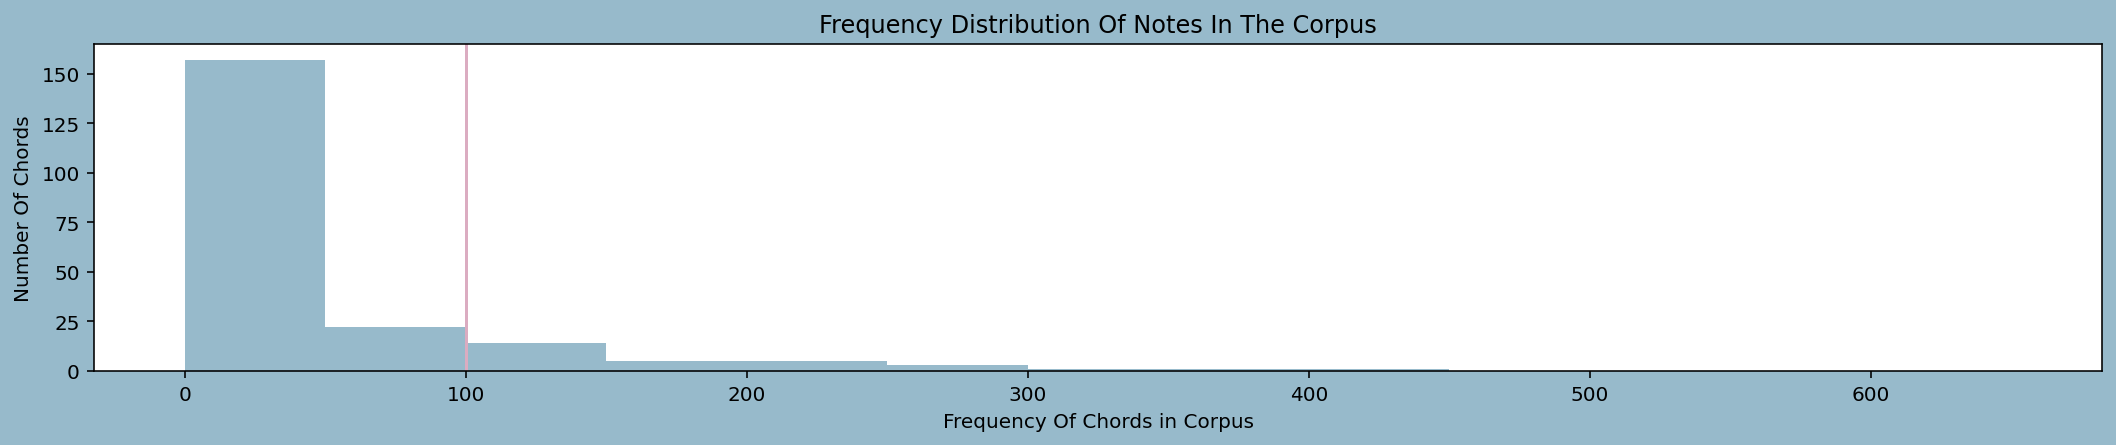

In [21]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [22]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 179


In [23]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 7206


## DATA PREPROCESSING

In [24]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 7206
Number of unique characters: 160


In [25]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 7166


In [26]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [27]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## MODEL BUILDING

In [28]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [29]:
#Model's Summary               
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        41,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,947,040 (7.43 MB)

 Trainable params: 1,947,040 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=10)

Epoch 1/10


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 437ms/step - loss: 4.6742
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 3.9033
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - loss: 3.8799
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - loss: 3.8725
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - loss: 3.8658
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - loss: 3.8765
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - loss: 3.8900
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 3.8741
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 3.8578
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 3.8303


## Evaluating Model

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

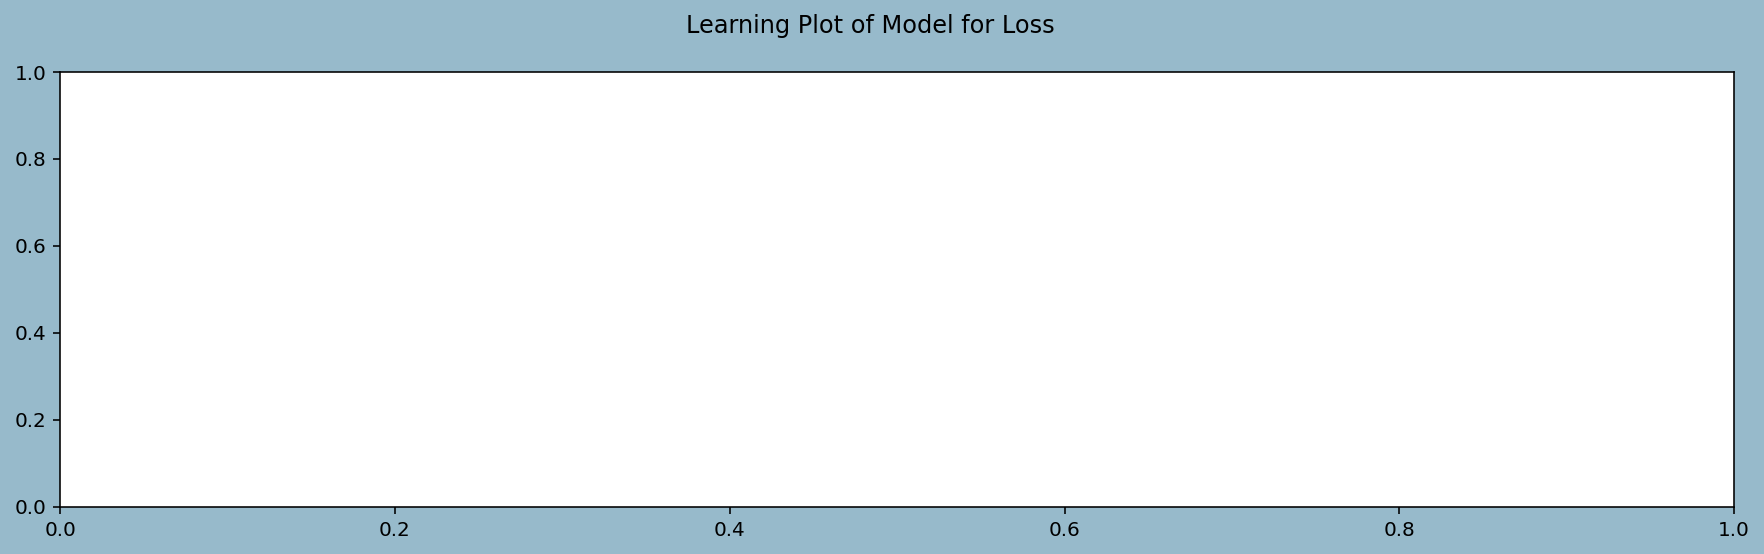

In [34]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


# #getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
# show(Melody)

In [ ]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')
#to play audio or corpus
FluidSynth().play_midi('./Melody_Generated.mid')